In [1]:
import pandas as pd
import numpy as np
from datetime import date
import random 
import hts
from hts.hierarchy import HierarchyTree

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric

import matplotlib.pyplot as plt
import seaborn as sns
from imp import reload


import warnings
warnings.simplefilter("ignore")

# settings
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (16, 8)

In [2]:
import forecasting.store_item_demand as sid
import forecasting.bplot as bplot

In [3]:
reload(sid);

# Load and Preprocess

In [4]:
df, df_h, hierarchy = sid.preprocess_data('../data/train.csv')


# no null entries
# 10 stores
# 50 items
# 50*10=500 separate time series, one for each store/item combination
# 1826 days = 5 years
# 1826*500 = 913'000 rows of sales data
    
Number of time series at the bottom level: 500
Number of time series at the middle level: 10
Number of time series at the top level   : 1


In [5]:
tree = HierarchyTree.from_nodes(hierarchy, df_h, root='total')

# First look at the data

## Share of total sales by store

In [103]:
reload(sid);

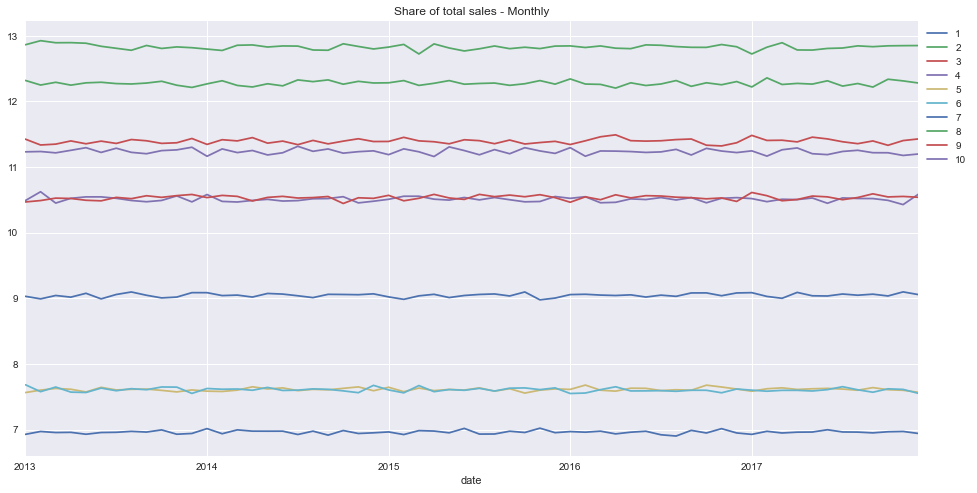

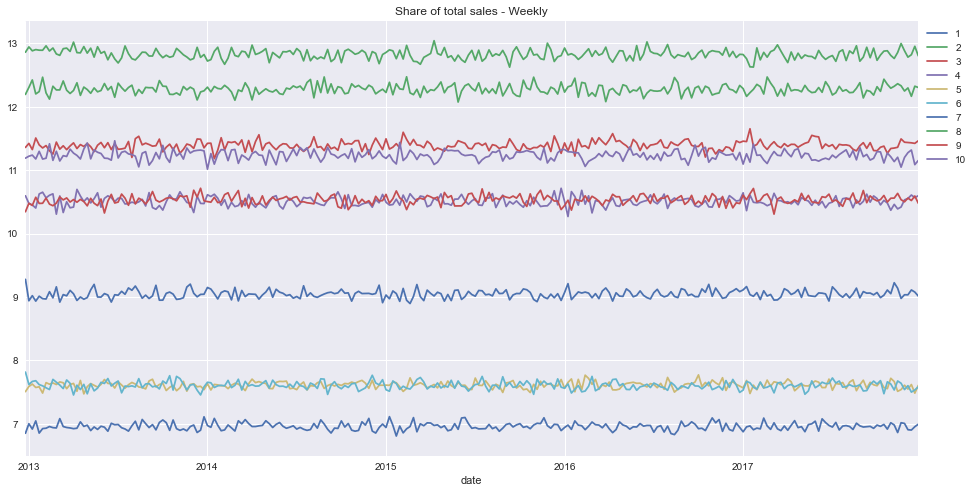

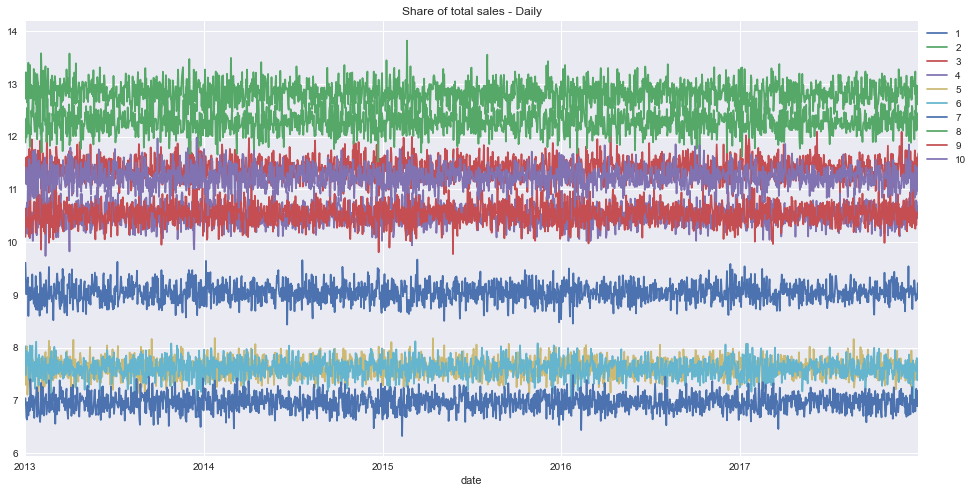

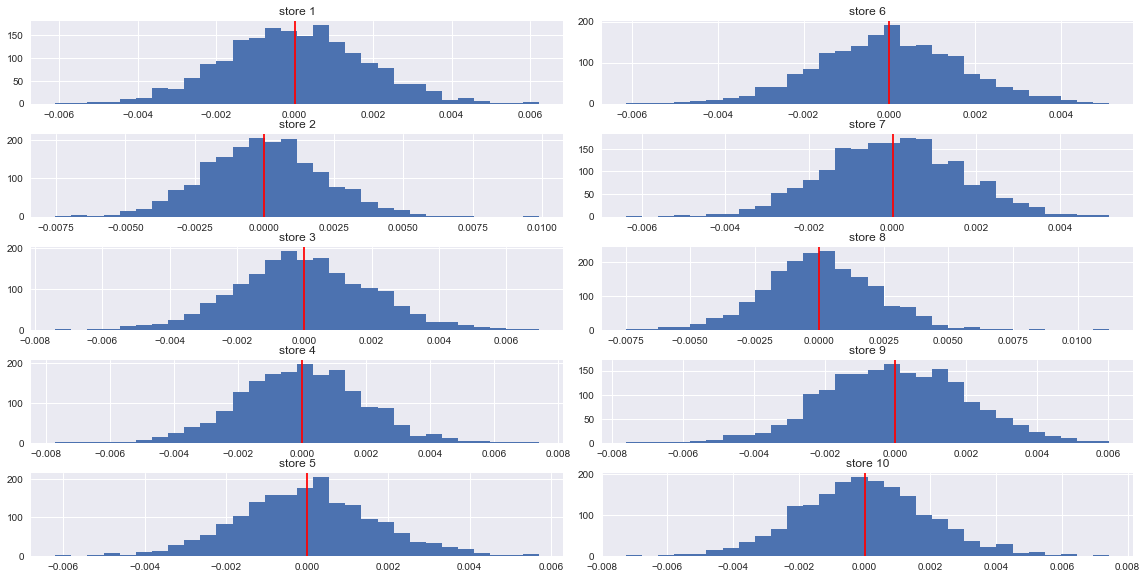

In [104]:
df_res = sid.do_share_by_store_analysis(df_h, hierarchy)

In [105]:
df_res.head()

,1,2,3,4,5,6,7,8,9,10
date,,,,,,,,,,
2013-01-01,0.005632,-0.001107,0.002011,-0.001185,-0.000763,0.004185,0.000785,-0.003899,-0.004354,-0.001306
2013-01-02,0.001957,0.003886,-0.001492,-0.000391,-0.003223,-0.001266,-0.000584,0.000571,0.001043,-0.000502
2013-01-03,-0.000380,0.001949,-0.001083,0.000796,0.001882,0.003250,-0.002925,-0.002942,-0.002350,0.001803
2013-01-04,0.002165,-0.001806,-0.002881,0.002398,0.004132,0.000552,-0.003261,0.002641,-0.002506,-0.001434
2013-01-05,0.001866,0.000236,0.002281,-0.003526,-0.005041,0.003145,0.000055,0.000718,-0.000756,0.001022


## Share of store sales by item

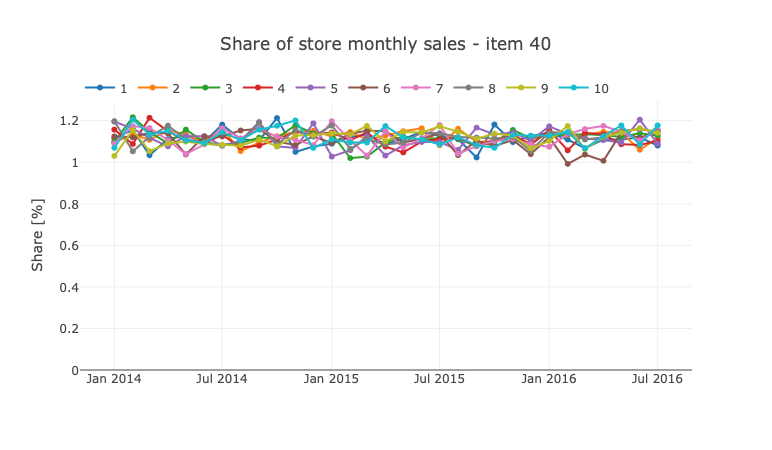

In [125]:
df_month_interval = df_month['2014-01-01':'2016-07-01']
for item in random.sample(range(50), 1):
    in_store_share = []
    for s in hierarchy['total']:
        in_store_share.append(df_month_interval[f'{s}_{item}'].\
                              divide(df_month_interval[s], axis=0)*100)

    bplot.plot_timeseries(in_store_share, labels=hierarchy['total'],
                          title = f'Share of store monthly sales - item {item}', 
                          ylabel='Share [%]', y_range=None)

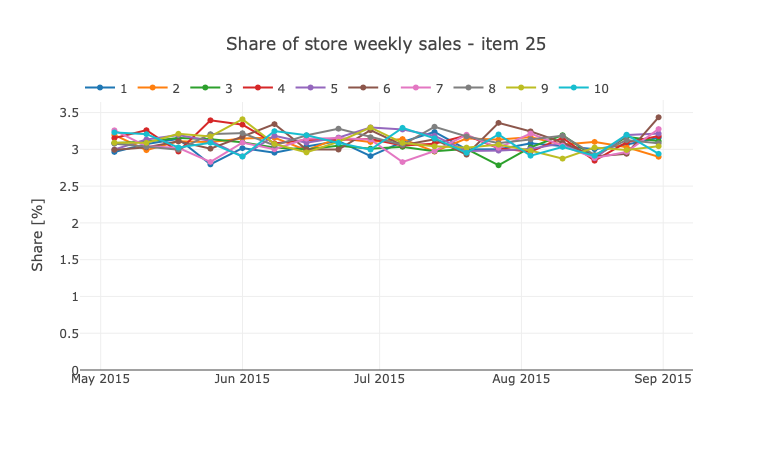

In [134]:
df_interval = df_week['2015-05-01':'2015-09-01']
for item in random.sample(range(50), 1):
    in_store_share = []
    for s in hierarchy['total']:
        in_store_share.append(df_interval[f'{s}_{item}'].divide(df_interval[s], axis=0)*100)

    bplot.plot_timeseries(in_store_share, labels=hierarchy['total'],
                          title = f'Share of store weekly sales - item {item}', 
                          ylabel='Share [%]', y_range=None)

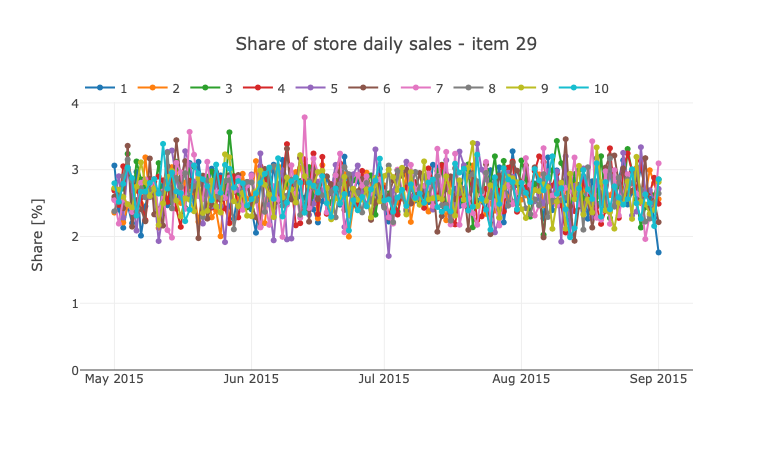

In [135]:
df_interval = df_h['2015-05-01':'2015-09-01']
for item in random.sample(range(50), 1):
    in_store_share = []
    for s in hierarchy['total']:
        in_store_share.append(df_interval[f'{s}_{item}'].divide(df_interval[s], axis=0)*100)

    bplot.plot_timeseries(in_store_share, labels=hierarchy['total'],
                          title = f'Share of store daily sales - item {item}', 
                          ylabel='Share [%]', y_range=None)

In [6]:
df_perc_tot = df_h.divide(df_h['total'],axis=0)

In [7]:
list(range(1,11))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [8]:
r_stores = random.sample(range(1,11),5)
r_items  = random.sample(range(1,51),5)

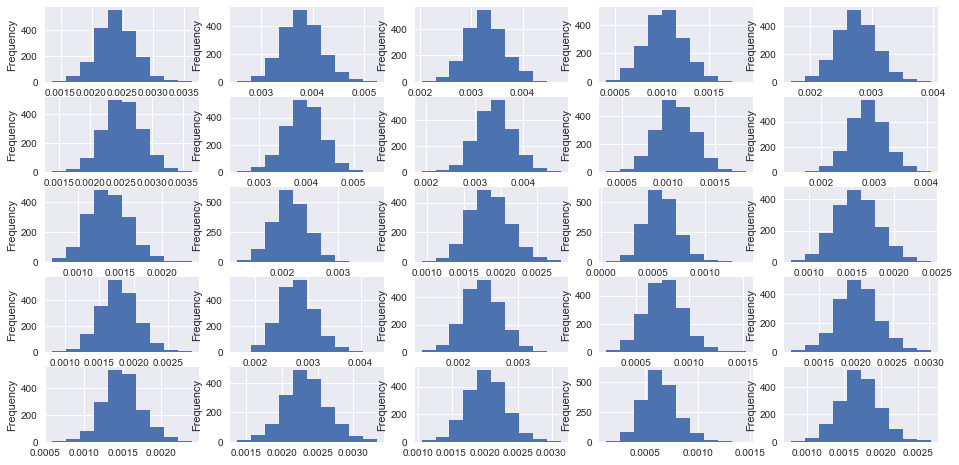

In [9]:
fig, axs = plt.subplots(5, 5)
for x in range(5):
    for y in range(5):
        df_perc_tot[f'{r_stores[x]}_{r_items[y]}'].plot.hist(ax=axs[x,y])

In [10]:
store_items_list = [f'{s}_{i}' for s in range(1,11) for i in range(1,51)]

sigma_over_mean_ratios = []
for si in store_items_list:
    mean = df_perc_tot[si].mean()
    sigma = df_perc_tot[si].std()
    sigma_over_mean_ratios.append( sigma/mean)

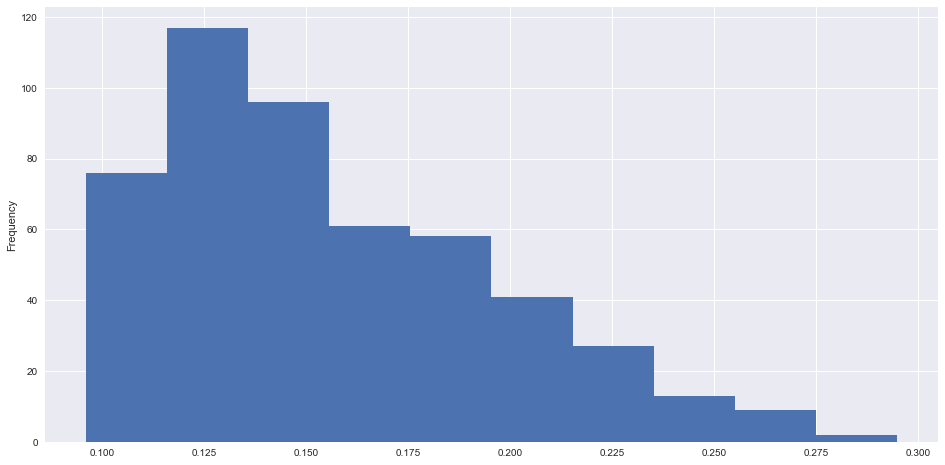

In [17]:
pd.Series(sigma_over_mean_ratios).plot.hist()

In [11]:
lmean = np.mean(sigma_over_mean_ratios)
lmin  = np.min(sigma_over_mean_ratios)
lmax  = np.max(sigma_over_mean_ratios)

In [15]:
print(f'mean, min, max: {lmean:.2f}, {lmin:.2f}, {lmax:.2f}')

mean, min, max: 0.16, 0.10, 0.29


In [24]:
perc_tot_mean = df_perc_tot.mean()

In [83]:
df_input_prophet = df_h['total'].copy().reset_index()
df_input_prophet.columns = ['ds','y']

In [138]:
custom_event = pd.DataFrame({
  'holiday': 'unkown',
  'ds': pd.to_datetime(['2014-11-30', 
                        '2015-11-30',
                        '2016-11-30',
                        '2017-11-30']),
  'lower_window': -4,
  'upper_window': 1,
})

In [136]:
custom_event

,holiday,ds,lower_window,upper_window
0,unkown,2014-11-30,4,1
1,unkown,2015-11-30,4,1
2,unkown,2016-11-30,4,1
3,unkown,2017-11-30,4,1


In [139]:
m = Prophet(yearly_seasonality=True, 
            weekly_seasonality=True, 
            daily_seasonality=False,
            holidays=custom_event
            #seasonality_mode='multiplicative')
           )
m.fit(df_input_prophet)
future = m.make_future_dataframe(periods=90)
df_forecast = m.predict(future)

In [46]:
df_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2013-01-01,20863.719005,12067.108346,14679.965956,20863.719005,20863.719005,-0.356778,-0.356778,-0.356778,-0.076606,-0.076606,-0.076606,-0.280172,-0.280172,-0.280172,0.0,0.0,0.0,13420.009670
1,2013-01-02,20868.687553,12117.523213,14832.949233,20868.687553,20868.687553,-0.355633,-0.355633,-0.355633,-0.073819,-0.073819,-0.073819,-0.281814,-0.281814,-0.281814,0.0,0.0,0.0,13447.100856
2,2013-01-03,20873.656102,13417.881224,16141.771566,20873.656102,20873.656102,-0.293271,-0.293271,-0.293271,-0.009593,-0.009593,-0.009593,-0.283678,-0.283678,-0.283678,0.0,0.0,0.0,14752.017927
3,2013-01-04,20878.624650,14703.494868,17459.070607,20878.624650,20878.624650,-0.229851,-0.229851,-0.229851,0.055863,0.055863,0.055863,-0.285714,-0.285714,-0.285714,0.0,0.0,0.0,16079.644244
4,2013-01-05,20883.593199,16123.117588,19055.294248,20883.593199,20883.593199,-0.164967,-0.164967,-0.164967,0.122896,0.122896,0.122896,-0.287864,-0.287864,-0.287864,0.0,0.0,0.0,17438.487146


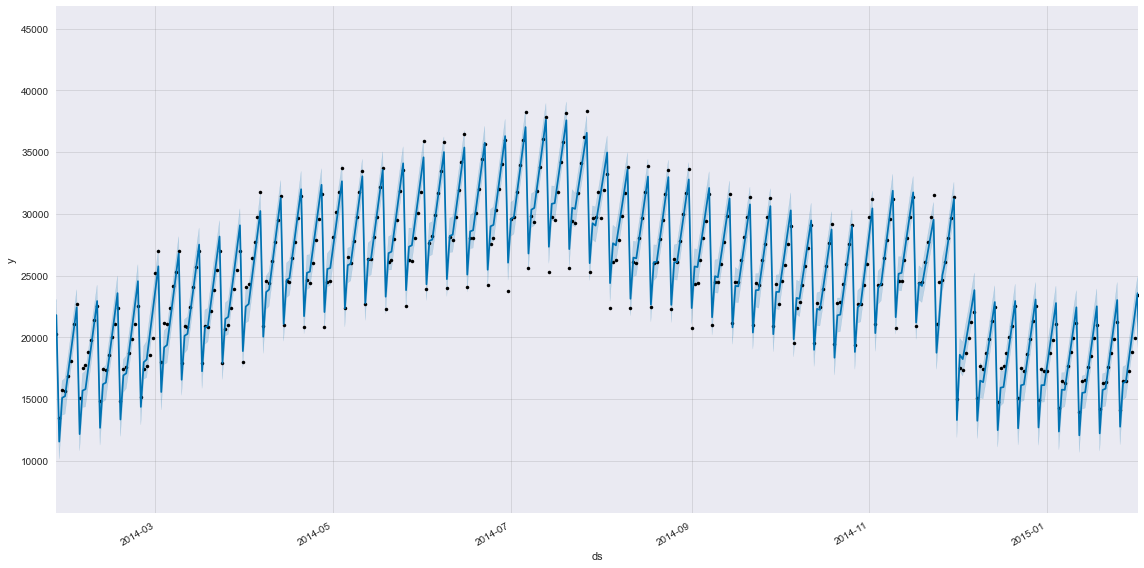

In [140]:
fig, ax = plt.subplots()
fig.autofmt_xdate()
ax.set_xlim([date(2014, 1, 26), date(2015, 2, 1)])
fig1 = m.plot(df_forecast, ax)

In [142]:
merged_df = df_input_prophet.set_index('ds').join(df_forecast.set_index('ds'))

In [143]:
df_my_deltas = (merged_df['y'] - merged_df['yhat']).divide( (merged_df['yhat_upper']-merged_df['yhat_lower'])/2,
                                            axis=0)

### Outlier detection

In [144]:
df_my_deltas[df_my_deltas>2]

ds
2013-02-04    2.132067
2013-03-04    2.074376
2013-11-27    2.073644
2013-11-28    2.116222
2013-11-29    2.404945
2013-11-30    2.609946
2014-01-06    2.139773
2014-01-13    2.004205
2014-02-03    2.104413
2014-11-25    2.067376
2016-04-03    2.033151
2016-07-30    2.483822
2016-07-31    2.999335
2016-11-25    2.365212
2017-04-02    2.050041
2017-06-04    2.162451
2017-07-01    2.389512
2017-07-02    2.837530
2017-07-23    2.306894
2017-07-29    2.459213
2017-07-30    3.308364
2017-11-25    2.600126
dtype: float64

In [118]:
df_my_deltas[df_my_deltas>2]

ds
2013-02-04    2.055356
2014-01-13    2.001607
2014-02-03    2.110635
2014-11-28    2.339638
2014-11-29    2.437944
2014-11-30    2.801634
2015-11-28    2.107180
2015-11-29    2.576225
2015-11-30    2.189072
2016-07-30    2.107302
2016-07-31    2.814386
2016-11-26    2.174618
2016-11-27    2.567965
2016-11-28    2.063956
2016-11-29    2.830226
2016-11-30    2.885810
2017-07-01    2.276170
2017-07-02    2.697689
2017-07-23    2.198115
2017-07-29    2.228995
2017-07-30    3.102242
2017-11-26    2.416144
2017-11-28    2.082766
2017-11-29    2.316414
2017-11-30    2.952531
dtype: float64

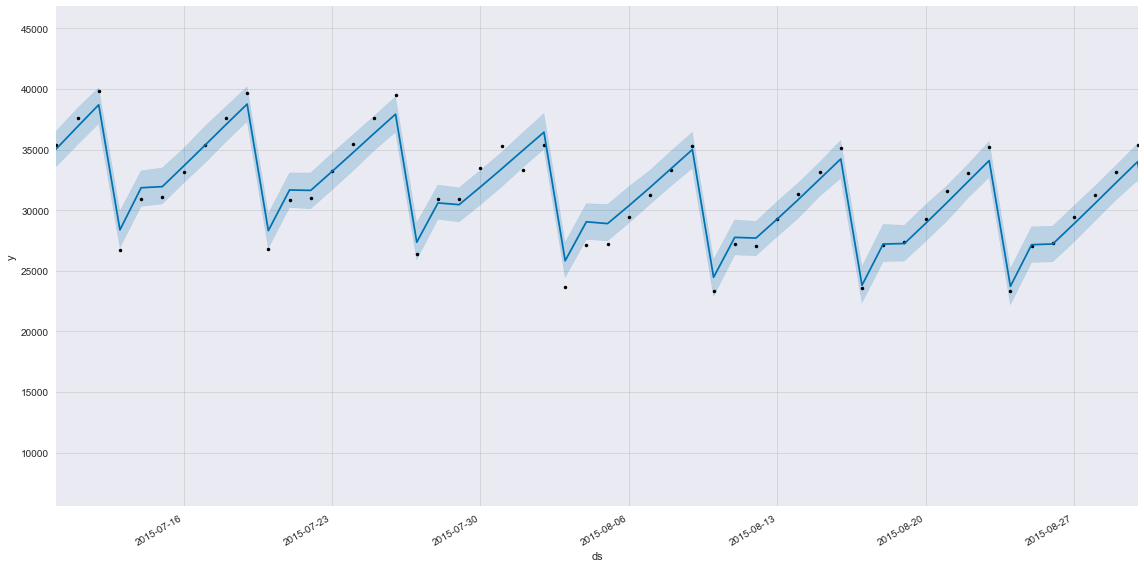

In [128]:
fig, ax = plt.subplots()
fig.autofmt_xdate()
ax.set_xlim([date(2015, 7, 10), date(2015, 8, 30)])
fig1 = m.plot(df_forecast, ax)

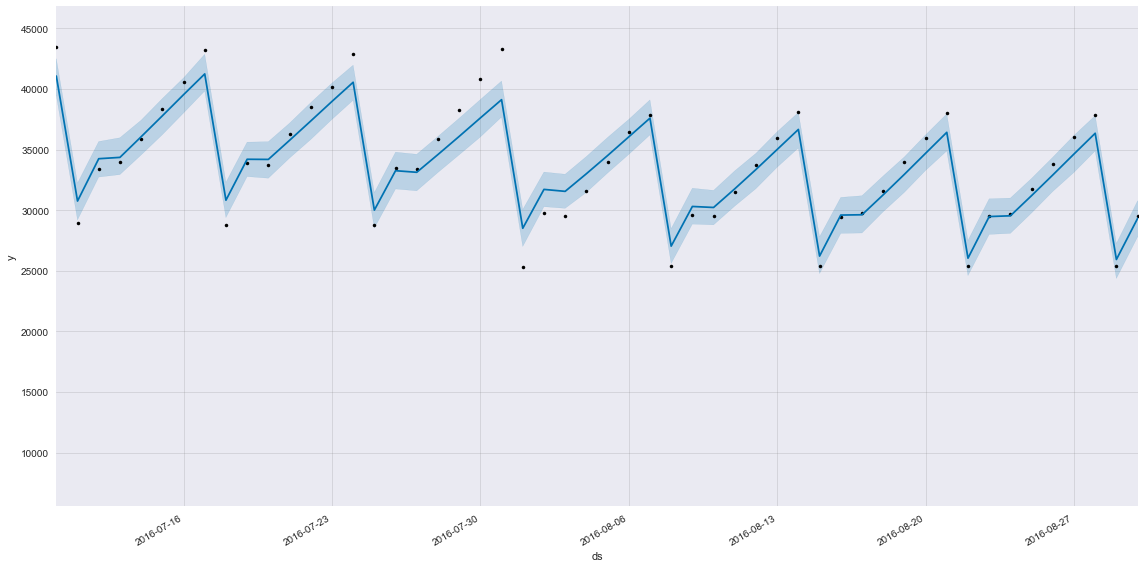

In [126]:
fig, ax = plt.subplots()
fig.autofmt_xdate()
ax.set_xlim([date(2016, 7, 10), date(2016, 8, 30)])
fig1 = m.plot(df_forecast, ax)

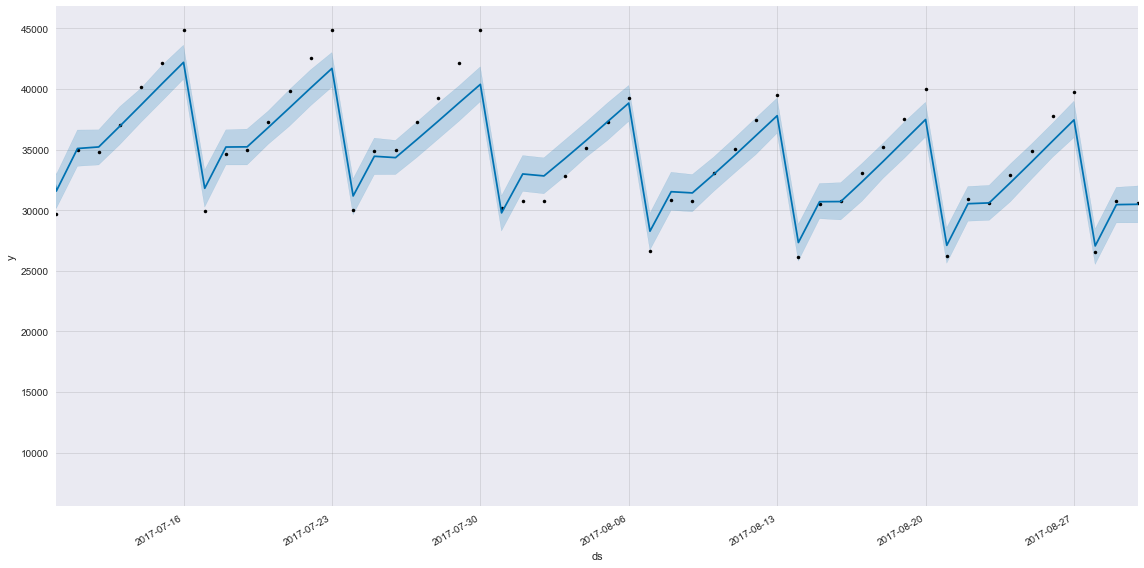

In [125]:
fig, ax = plt.subplots()
fig.autofmt_xdate()
ax.set_xlim([date(2017, 7, 10), date(2017, 8, 30)])
fig1 = m.plot(df_forecast, ax)

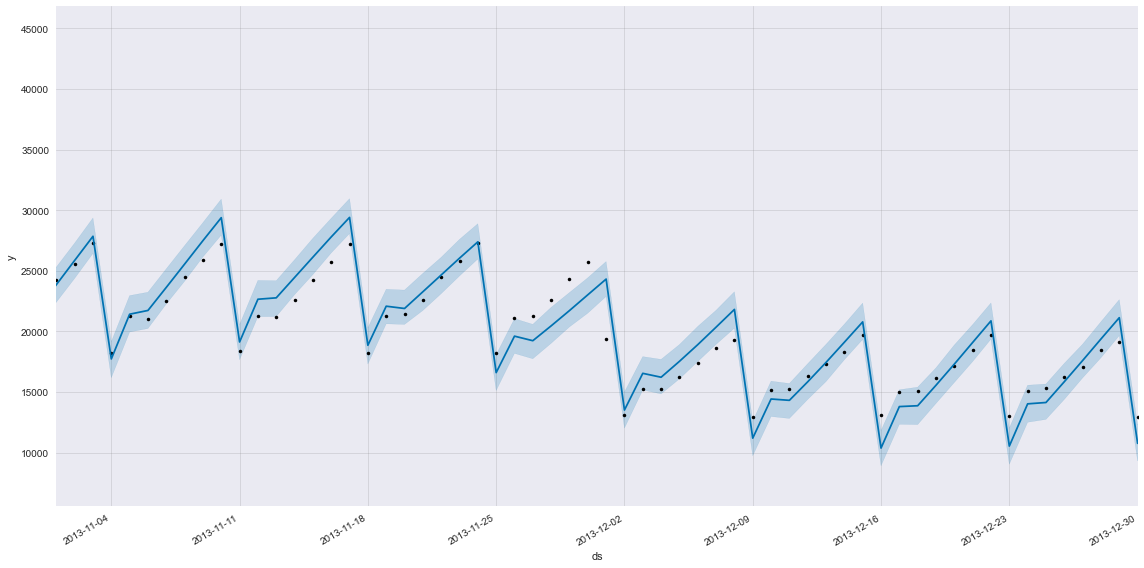

In [129]:
fig, ax = plt.subplots()
fig.autofmt_xdate()
ax.set_xlim([date(2013, 11, 1), date(2013, 12, 30)])
fig1 = m.plot(df_forecast, ax)

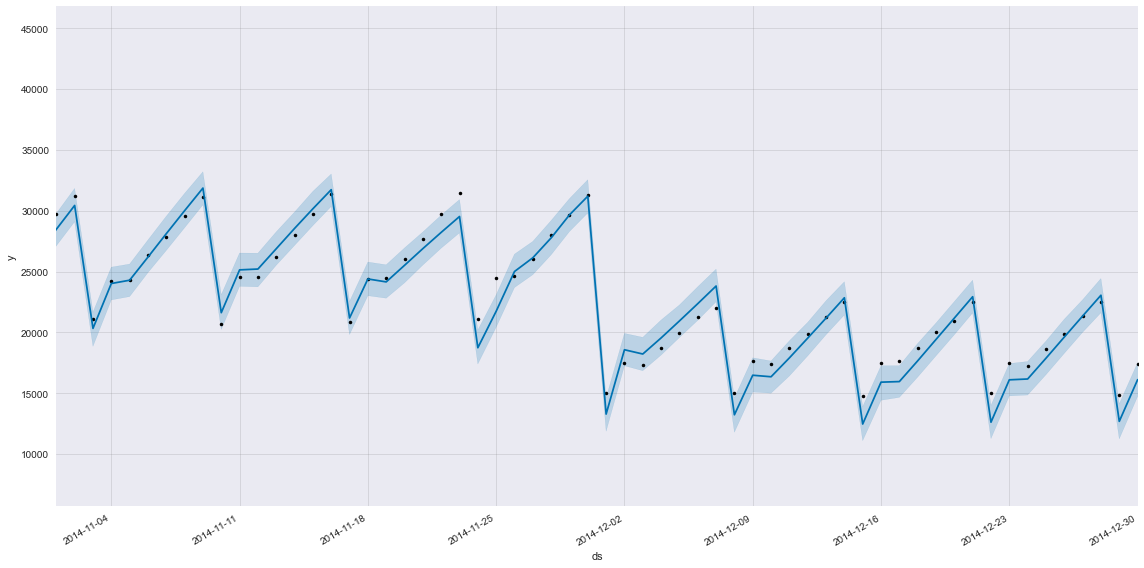

In [145]:
fig, ax = plt.subplots()
fig.autofmt_xdate()
ax.set_xlim([date(2014, 11, 1), date(2014, 12, 30)])
fig1 = m.plot(df_forecast, ax)

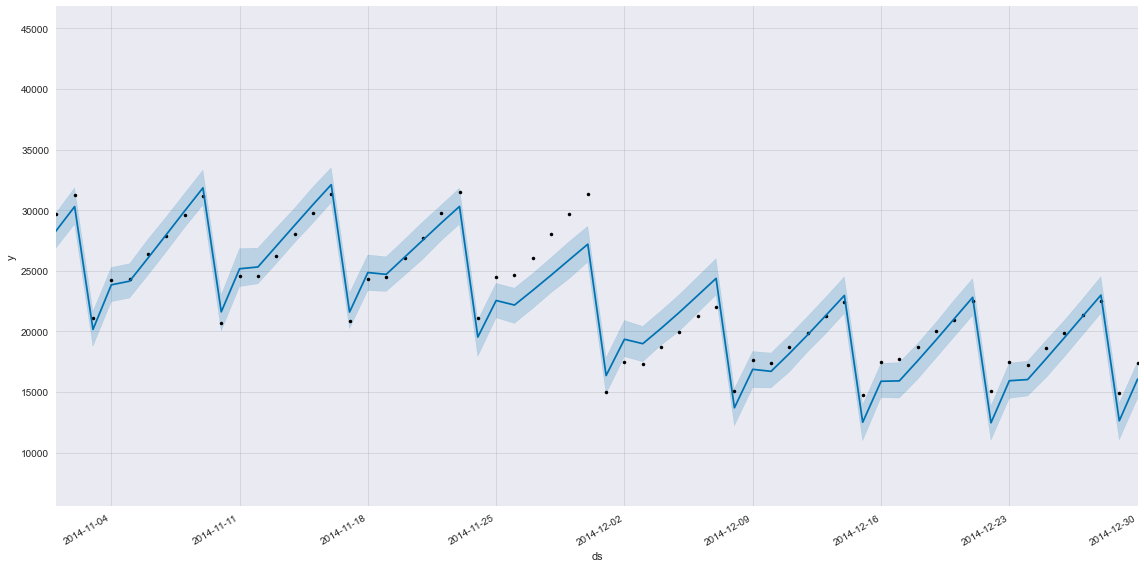

In [110]:
fig, ax = plt.subplots()
fig.autofmt_xdate()
ax.set_xlim([date(2014, 11, 1), date(2014, 12, 30)])
fig1 = m.plot(df_forecast, ax)

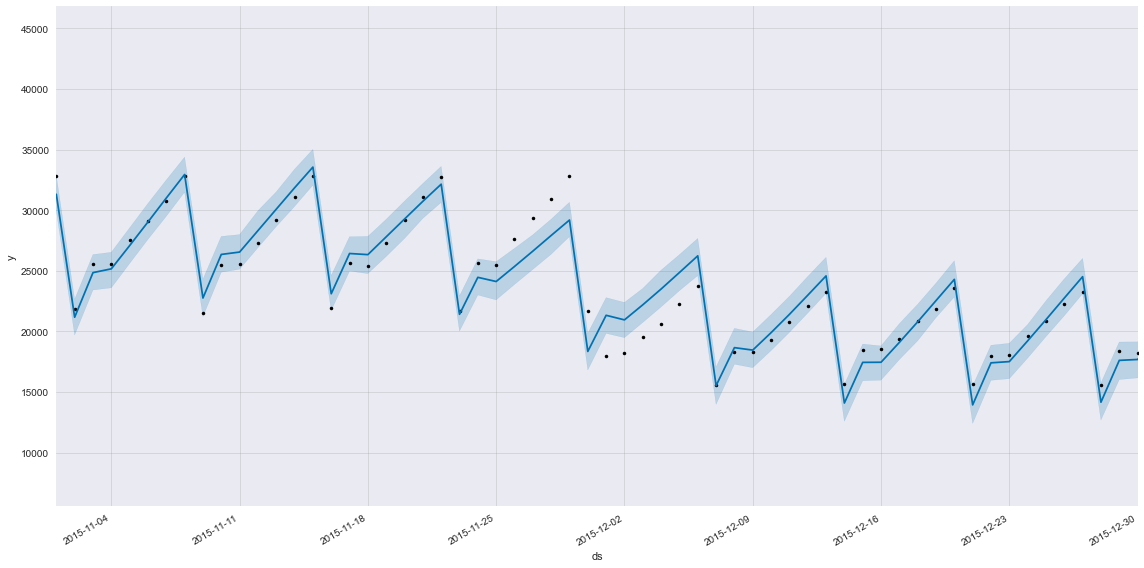

In [111]:
fig, ax = plt.subplots()
fig.autofmt_xdate()
ax.set_xlim([date(2015, 11, 1), date(2015, 12, 30)])
fig1 = m.plot(df_forecast, ax)

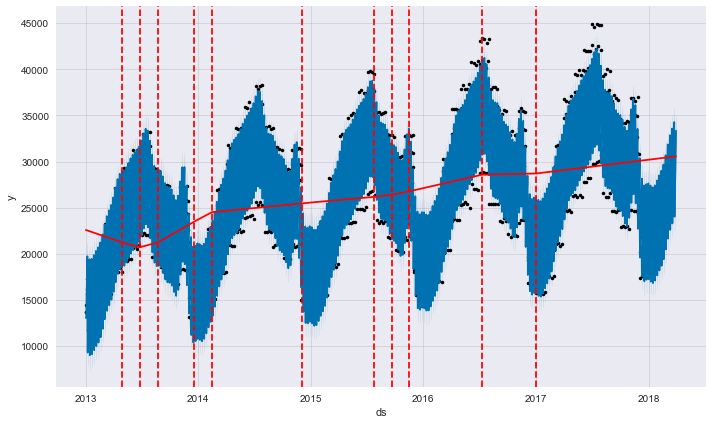

In [131]:
from prophet.plot import add_changepoints_to_plot
fig = m.plot(df_forecast)
a = add_changepoints_to_plot(fig.gca(), m, df_forecast)

In [133]:
m.changepoints

58     2013-02-28
117    2013-04-28
175    2013-06-25
233    2013-08-22
292    2013-10-20
350    2013-12-17
409    2014-02-14
467    2014-04-13
525    2014-06-10
584    2014-08-08
642    2014-10-05
700    2014-12-02
759    2015-01-30
817    2015-03-29
875    2015-05-26
934    2015-07-24
992    2015-09-20
1050   2015-11-17
1109   2016-01-15
1167   2016-03-13
1226   2016-05-11
1284   2016-07-08
1342   2016-09-04
1401   2016-11-02
1459   2016-12-30
Name: ds, dtype: datetime64[ns]

In [94]:
df_input_prophet.columns

Index(['ds', 'y'], dtype='object')

In [86]:
df_forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [93]:
df_forecast.apply(lambda row: max(row['yhat']-)

,yhat,yhat_lower,yhat_upper
0,13056.297796,11556.698283,14591.438266
1,13081.454520,11633.626814,14483.041316
2,14706.683474,13225.874969,16118.105105
3,16366.760846,14885.543369,17662.788817
4,18059.231045,16563.699270,19499.186344
...,...,...,...
1911,27581.602044,26089.448819,29148.842586
1912,27779.223765,26322.162664,29203.823984
1913,29589.330994,28104.861064,31103.964225
1914,31445.313748,29932.473297,32954.708863


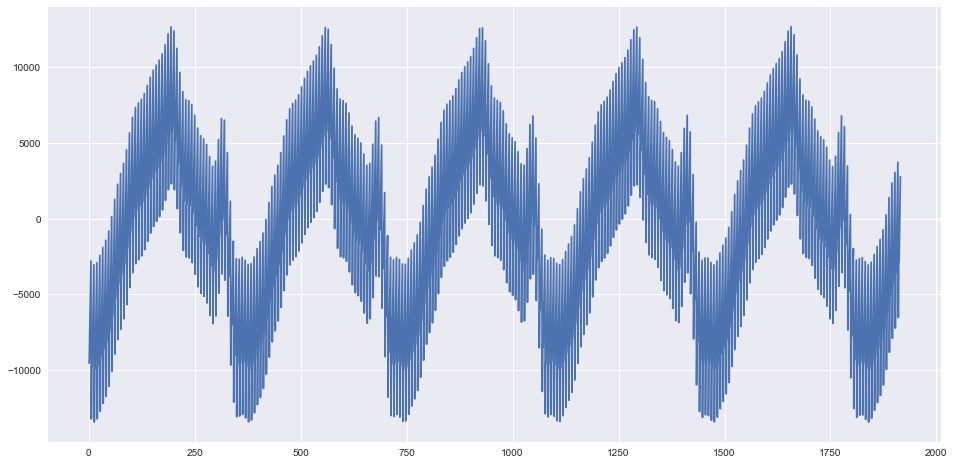

In [89]:
df_forecast['additive_terms'].plot()

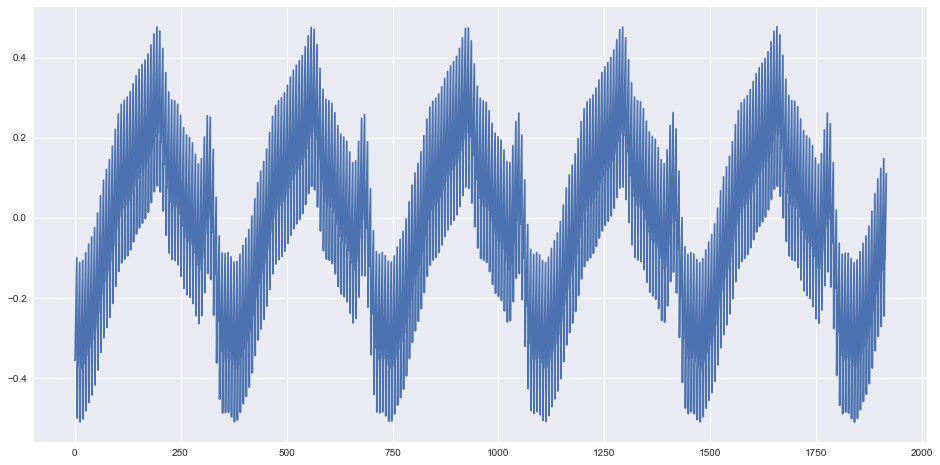

In [82]:
df_forecast['multiplicative_terms'].plot()

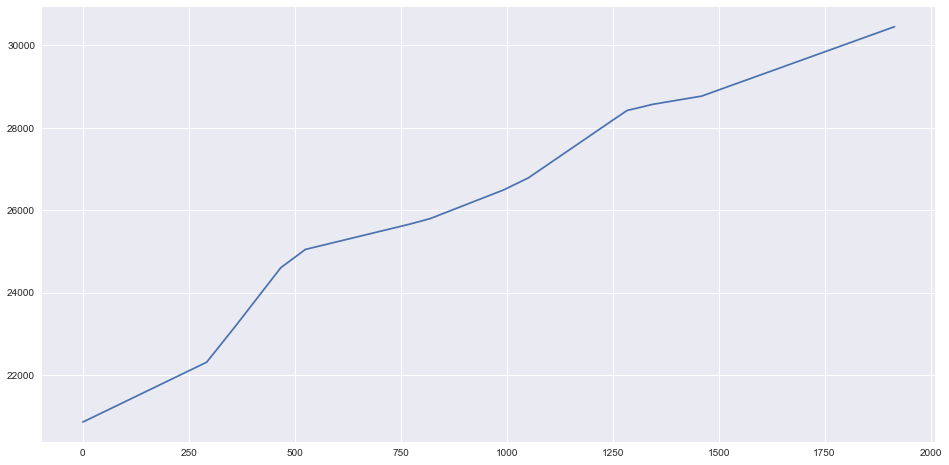

In [79]:
df_forecast['trend'].plot()

In [53]:
type(fig1)

matplotlib.figure.Figure

In [ ]:
fig1 = m.plot

In [42]:
df_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2013-01-01,20863.719005,12067.108346,14679.965956,20863.719005,20863.719005,-0.356778,-0.356778,-0.356778,-0.076606,-0.076606,-0.076606,-0.280172,-0.280172,-0.280172,0.0,0.0,0.0,13420.009670
1,2013-01-02,20868.687553,12117.523213,14832.949233,20868.687553,20868.687553,-0.355633,-0.355633,-0.355633,-0.073819,-0.073819,-0.073819,-0.281814,-0.281814,-0.281814,0.0,0.0,0.0,13447.100856
2,2013-01-03,20873.656102,13417.881224,16141.771566,20873.656102,20873.656102,-0.293271,-0.293271,-0.293271,-0.009593,-0.009593,-0.009593,-0.283678,-0.283678,-0.283678,0.0,0.0,0.0,14752.017927
3,2013-01-04,20878.624650,14703.494868,17459.070607,20878.624650,20878.624650,-0.229851,-0.229851,-0.229851,0.055863,0.055863,0.055863,-0.285714,-0.285714,-0.285714,0.0,0.0,0.0,16079.644244
4,2013-01-05,20883.593199,16123.117588,19055.294248,20883.593199,20883.593199,-0.164967,-0.164967,-0.164967,0.122896,0.122896,0.122896,-0.287864,-0.287864,-0.287864,0.0,0.0,0.0,17438.487146


In [124]:
#ax = df_share_by_store.plot(title="Share by store")
#ax.legend(bbox_to_anchor=(1.0, 1.0));
#ax.set_ylim([0.06,.14]);

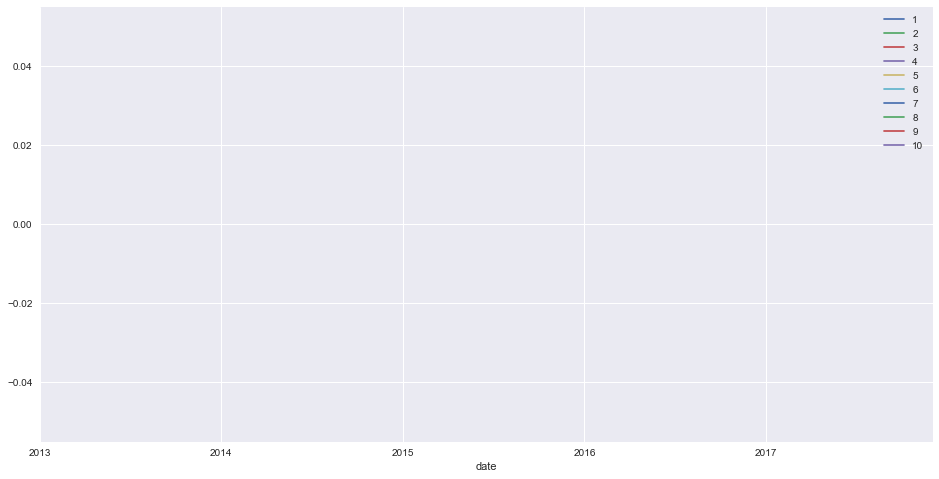

In [22]:
df_over_total[hierarchy['total']].plot()

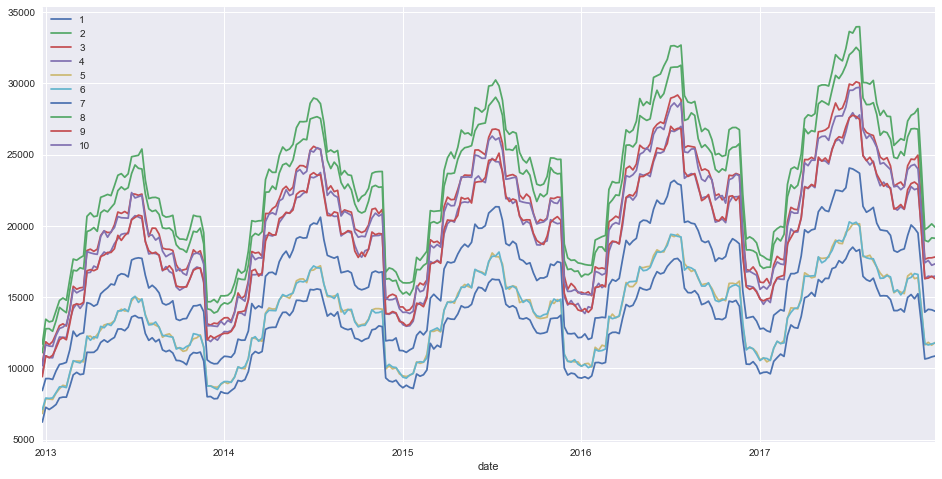

In [12]:
df_week[hierarchy['total']].plot()

In [6]:
#HierarchyTree.from_nodes(hierarchy, h_df, root='total')

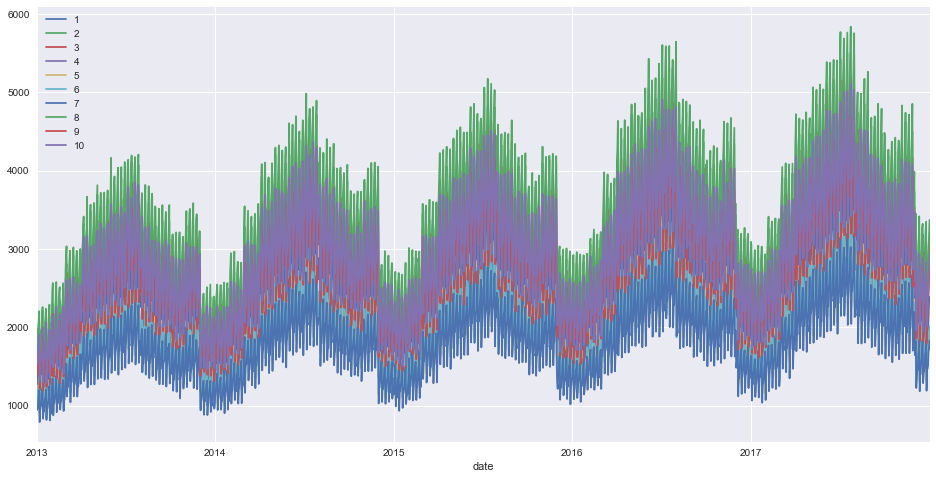

In [7]:
df_h[hierarchy['total']].plot()

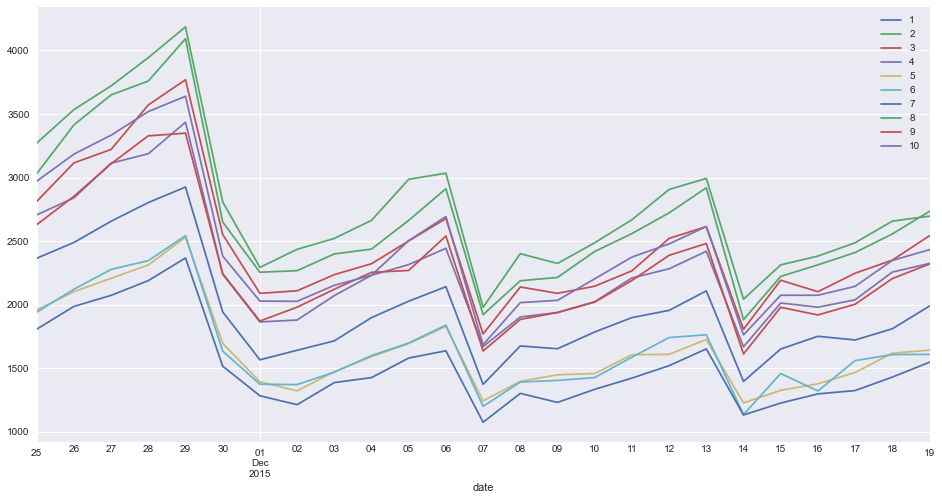

In [8]:
df_h['2015-11-25':'2015-12-19'][hierarchy['total']].plot()

In [9]:
#df_h[hierarchy['total']].plot()

# Testing Prophet

In [ ]:
df_prophet = df_h['1'].to_frame().reset_index()
df_prophet.columns = ['ds', 'y']

In [ ]:
df_prophet.head()

In [ ]:
m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)

In [ ]:
m.fit(df_prophet)

In [ ]:
future = m.make_future_dataframe(periods=90)

In [ ]:
df_forecast = m.predict(future)

In [ ]:
df_forecast.head()

In [ ]:
fig, ax = plt.subplots()
ax.set_xlim([datetime.date(2017, 1, 1), datetime.date(2018, 1, 1)])
fig1 = m.plot(df_forecast, ax)

In [ ]:
fig, ax = plt.subplots()
ax.set_xlim([datetime.date(2017, 12, 1), datetime.date(2018, 1, 1)])
fig1 = m.plot(df_forecast, ax)

In [ ]:
fig2 = m.plot_components(df_forecast)

In [ ]:
#plot_plotly(m, df_forecast)

In [ ]:
plot_components_plotly(m, df_forecast)

In [ ]:
df_p = performance_metrics(df_cv)
df_p['horizon'] = df_p['horizon'].apply(lambda x: int(str(x).split()[0]))

In [ ]:
df_p.set_index('horizon', inplace=True)

In [ ]:
trace = df_p['smape']*100.

In [ ]:
reload(bplot);

In [ ]:
bplot.plot_timeseries([trace], labels=['smape'], xlabel='horizon', ylabel='smape [%]')

# Cross-validation

In [ ]:
reload(sid);

## Store-level predictions

In [ ]:
stores = hierarchy['total']
store_cvs, store_perfs = sid.cv_loop(df_h, ts_list=stores, progress_bar=False)

In [ ]:
sid.cv_plot(store_perfs, id_label='store', metric='smape')

In [ ]:
store_perfs['1']

## Item-level predictions

In [ ]:
stores = hierarchy['total']
n_sample_stores = 3
n_sample_items = 5

In [ ]:
stores_sample = random.sample(stores, n_sample_stores)
item_perfs_all = {}
for s in stores_sample:
    items = hierarchy[s]
    items_sample = random.sample(items, n_sample_items)
    #print(items_sample)
    item_cvs, item_perfs = sid.cv_loop(df_h, ts_list=items_sample, progress_bar=False)
    sid.cv_plot(item_perfs, id_label='item')
    item_perfs_all.update(item_perfs)

In [ ]:
sum_smape   = 0
count_smape = 0
for k,v in item_perfs_all.items():
    sum_smape   += item_perfs_all[k]['smape'].sum()
    count_smape += item_perfs_all[k]['smape'].count()

In [ ]:
final_overall_smape = sum_smape/count_smape

In [ ]:
final_overall_smape

# Hierarchical time series forecasting

In [ ]:
xmin = '2015-01-01'
xmax = '2015-03-30'
x_range = [xmin, xmax]

In [ ]:
ax = df_h[hierarchy['total']].plot(title="Sales - store level")
ax.legend(bbox_to_anchor=(1.0, 1.0));
ax.set_xlim(x_range);

In [ ]:
ax = df_h[hierarchy['2'][16:17]].plot(title="Sales - item level")
ax.legend(bbox_to_anchor=(1.0, 1.0));
xmin = '2016-01-01'
xmax = '2016-02-01'
x_range = [xmin, xmax]
ax.set_xlim(x_range);

In [ ]:
ax = df_h[hierarchy['2'][40:50]].plot(title="Sales - item level")
ax.legend(bbox_to_anchor=(1.0, 1.0));
ax.set_xlim(x_range);

In [ ]:
#tree = HierarchyTree.from_nodes(hierarchy, df_h, root='total')

In [ ]:
reload(sid);

In [ ]:
pred_hts = sid.calc_store_hier_preds(hierarchy, df_h, store_idx='1')

In [ ]:
sid.plot_comparison(df_train=df_h, df_preds=pred_hts,
                    idx='1', xmin = '2017-09-20', xmax = None)

In [ ]:
sid.plot_comparison(df_train=df_h, df_preds=pred_hts,
                    idx='1_35', xmin = '2016-09-20', xmax = '2017-09-20')

# Model evaluation

In [45]:
reload(sid);

In [ ]:
#df_h, hierarchy

In [39]:
# Preparing the datasets for the simulated historical forecasts
shf_splits = sid.shf_split(df_h, n_years_min_training=3.5, horizon=90)


# full train start : '2013-01-01'
# full train end   : '2017-12-31'
# min train end    : '2016-07-01'
# horizon          :  90 days
    
# number of cutoffs: 7
2017-10-02
2017-08-18
2017-07-04
2017-05-20
2017-04-05
2017-02-19
2017-01-05


### Bottom-up with naive method

In [ ]:
# Getting forecasts for all SHF datasets
forecasts_dict = sid.shf_forecasts_loop(hierarchy, shf_splits, algo='naive',
                                        n_store=None, n_store_items=None, 
                                        verbose=False)

# Persist results so that we don't have to re-run this every-time
sid.write_pickle(filename='./bu_naive.pickle', obj=forecasts_dict)

In [42]:
df_perf = sid.eval_performance(forecasts_dict)

average SMAPE: 0.25


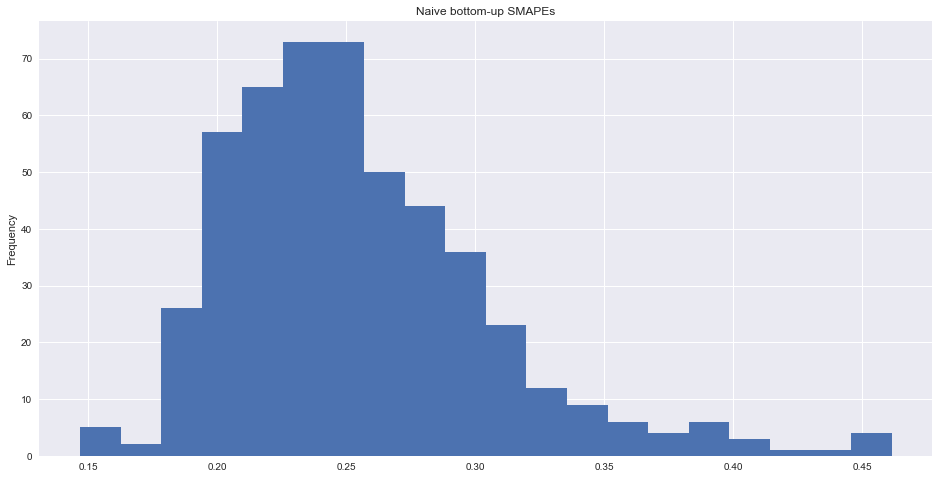

In [43]:
mean_smape = df_perf.query(f'h_days==90')['smape'].mean()
print(f'average SMAPE: {mean_smape:.2f}')
ax = df_perf.query(f'h_days==90')['smape'].plot(kind='hist', bins=20, 
                                                title='Naive bottom-up SMAPEs')

### Bottom-up with Average method

In [46]:
# Getting forecasts for all SHF datasets
forecasts_dict = sid.shf_forecasts_loop(hierarchy, shf_splits, algo='average',
                                        n_store=None, n_store_items=None, 
                                        verbose=False)

# Persist results so that we don't have to re-run this every-time
sid.write_pickle(filename='./bu_average.pickle', obj=forecasts_dict)

In [47]:
df_perf = sid.eval_performance(forecasts_dict)

average SMAPE: 0.24


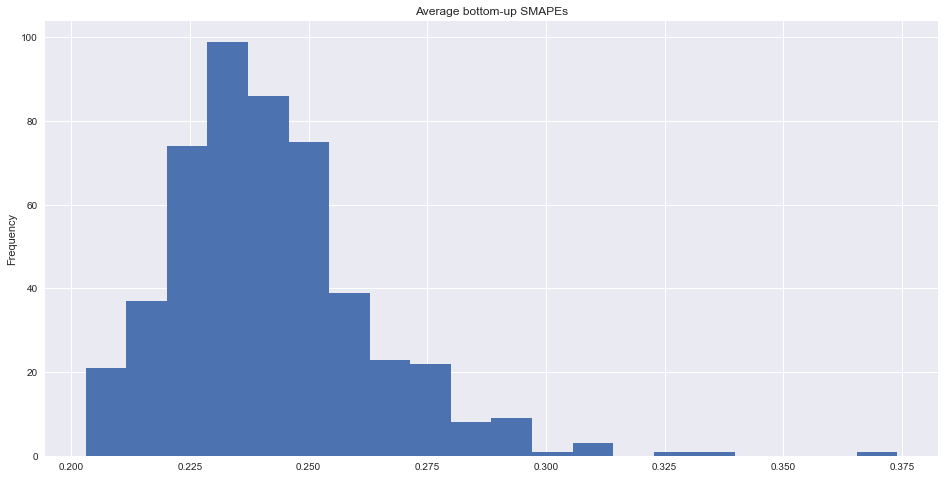

In [48]:
mean_smape = df_perf.query(f'h_days==90')['smape'].mean()
print(f'average SMAPE: {mean_smape:.2f}')
ax = df_perf.query(f'h_days==90')['smape'].plot(kind='hist', bins=20, 
                                                title='Average bottom-up SMAPEs')

### Bottom-up with Prophet

In [21]:
# Getting forecasts for all SHF datasets
forecasts_dict_prophet = sid.shf_forecasts_loop(hierarchy, shf_splits, algo='prophet',
                                                n_store=None, n_store_items=None, 
                                                verbose=True)

# Persist results so that we don't have to re-run this every-time
sid.write_pickle(filename='./test.pickle', obj=forecasts_dict_prophet)

In [183]:
# Reading results previously persisted
forecasts_dict_prophet = sid.read_pickle(filename='./prophet_results.pickle')

In [184]:
# Evaluating a bunch of performance metrics
df_perf_prophet = sid.eval_performance(forecasts_dict_prophet)

average SMAPE: 0.122


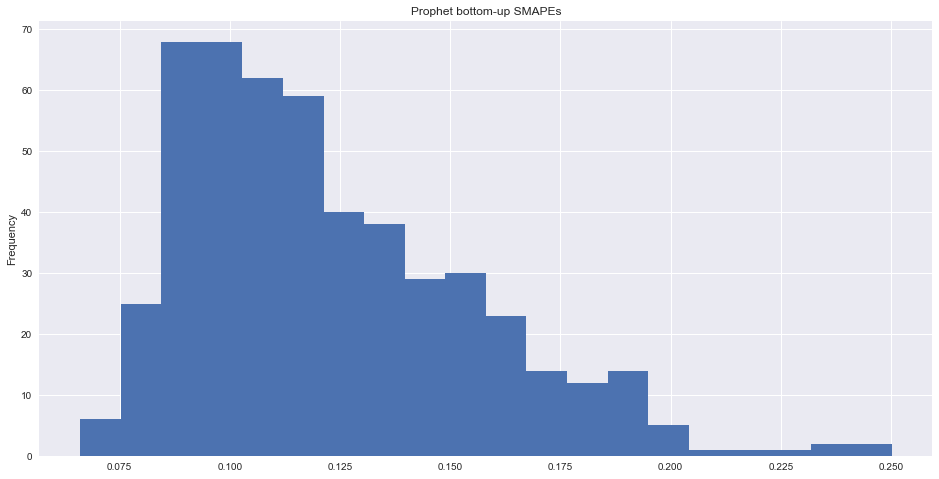

In [185]:
mean_smape = df_perf_prophet.query(f'h_days==90')['smape'].mean()
print(f'average SMAPE: {mean_smape:.3f}')
ax = df_perf_prophet.query(f'h_days==90')['smape'].plot(kind='hist', 
                                                        bins=20, 
                                                        title='Prophet bottom-up SMAPEs')

### As above, but with multiplicative seasonality

In [ ]:
# Getting forecasts for all SHF datasets
forecasts_dict_prophet = sid.shf_forecasts_loop(hierarchy, shf_splits, algo='prophet',
                                                n_store=None, n_store_items=None,
                                                seasonality_mode='multiplicative', H=90,
                                                verbose=True)

In [211]:
# Persist results so that we don't have to re-run this every-time
#sid.write_pickle(filename='./prophet_multiplicative.pickle', obj=forecasts_dict_prophet)

In [212]:
# Reading results previously persisted
forecasts_dict_hts = sid.read_pickle(filename='./prophet_multiplicative.pickle')

average SMAPE: 0.121


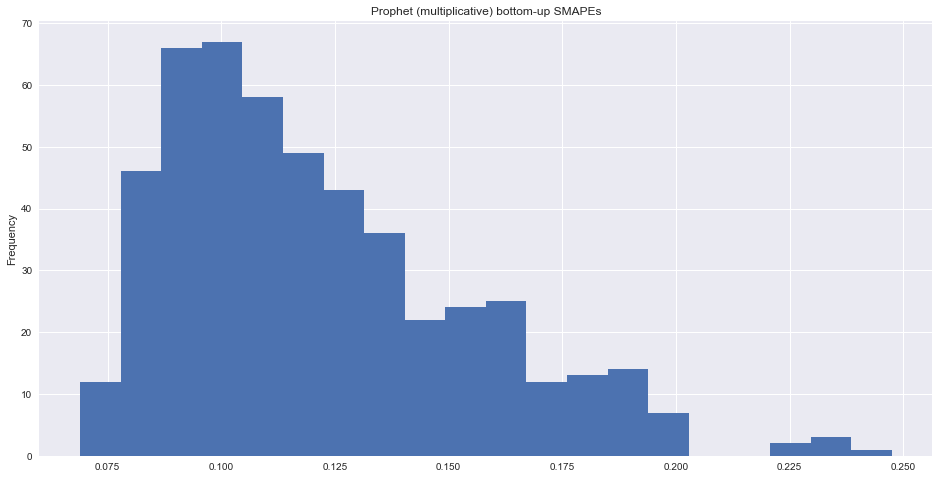

In [213]:
df_perf = sid.eval_performance(forecasts_dict_prophet)

mean_smape = df_perf.query(f'h_days==90')['smape'].mean()
print(f'average SMAPE: {mean_smape:.3f}')
ax = df_perf.query(f'h_days==90')['smape'].plot(kind='hist', bins=20, 
                                                title='Prophet (multiplicative) bottom-up SMAPEs')

### Hierarchical Optimal fit (2-levels) with Prophet

In [205]:
reload(sid);

In [ ]:
forecasts_dict = sid.shf_forecasts_loop_for_hier_method(hierarchy, shf_splits, 
                                                        n_store=None,
                                                        verbose=True, H=90)

# Persist results so that we don't have to re-run this every-time
sid.write_pickle(filename='./hts1.pickle', obj=forecasts_dict)

average SMAPE: 0.123


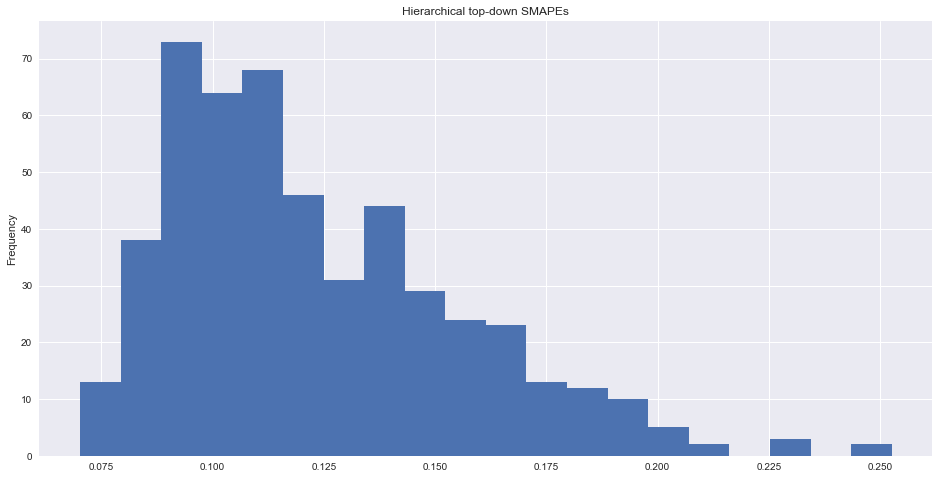

In [204]:
# Reading results previously persisted
forecasts_dict_hts = sid.read_pickle(filename='./hts1.pickle')

df_perf = sid.eval_performance(forecasts_dict_hts)

mean_smape = df_perf.query(f'h_days==90')['smape'].mean()
print(f'average SMAPE: {mean_smape:.3f}')
ax = df_perf.query(f'h_days==90')['smape'].plot(kind='hist', bins=20, 
                                                title='Hierarchical top-down SMAPEs')

## Detailed analysis of best model 

In [221]:
forecasts_dict_shf = sid.read_pickle(filename='./prophet_multiplicative.pickle')

In [222]:
df_perf = sid.eval_performance(forecasts_dict_shf)

average SMAPE: 0.126


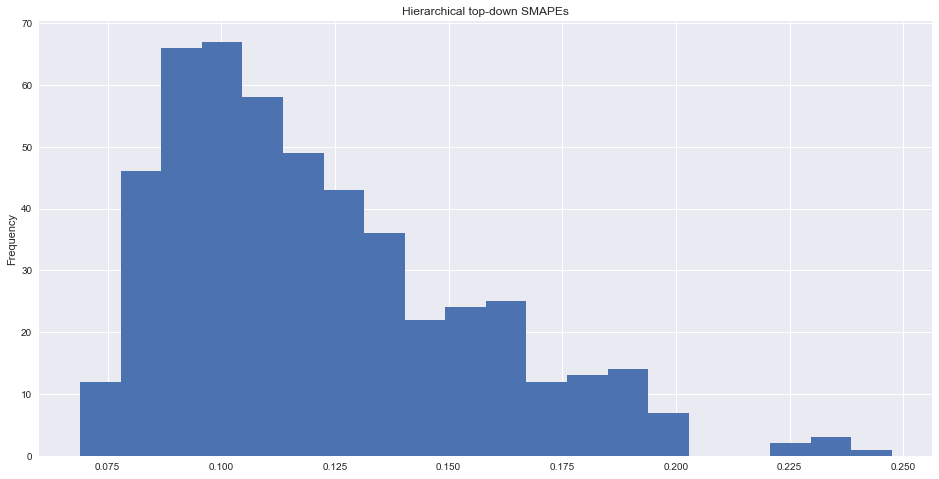

In [228]:
mean_smape = df_perf.query(f'h_days==10')['smape'].mean()
print(f'average SMAPE: {mean_smape:.3f}')
ax = df_perf.query(f'h_days==90')['smape'].plot(kind='hist', bins=20, 
                                                title='Hierarchical top-down SMAPEs')

In [231]:
df_perf.head()

,horizon,mse,rmse,mae,mape,mdape,smape,h_days,store_item
0,9 days,26.087541,5.107596,4.266050,0.253722,0.171698,0.215674,9,1_1
1,10 days,27.894907,5.281563,4.393916,0.243478,0.183127,0.213037,10,1_1
2,11 days,29.096898,5.394154,4.562426,0.245560,0.192421,0.218513,11,1_1
3,12 days,28.147768,5.305447,4.487805,0.239020,0.188243,0.213971,12,1_1
4,13 days,25.269122,5.026840,4.158886,0.233214,0.167242,0.202050,13,1_1
